# Team Assignment 2: Investing in Peer2Peer Lending - Beta 1  
#### Crystal Baker, Brooke Bordonaro, Saqib Ismail, Natalie McDonald, Cody Qiu, and Stefano Stompanato  

In developing a strategy for Dr. D to use to invest 10,000,000 dollars on Lending Club (LC), we wanted to look at the big picture and develop an approach that would allow Dr. D. to find the loans with the lowest risk and the highest return on investment (ROI). To do this, we knew that we needed to research the LC interface and investment process so that we could provide an applicable strategy for someone using the website as an investor. We found these characteristics about the LC investment process and kept them in mind during our analysis: investors must invest a minimum of 25 dollars in each loan they select and investors can choose to invest in loans picked manually or automatically selected loans via built-in options. These three built-in options (detailed here: https://www.lendingmemo.com/lending-club-strategy/) would automatically select loans based on certain grades and weights. We also made the assumption that traders were not an option due to the discontinuation by LC.

To meet our big picture goal of finding loans with the lowest risk and highest ROI, we decided to create a tool that, given a dataset of available loans, predicts which ones will be most profitable. After our exploratory data analysis and prediction tool creation, we came to these conclusions:

- About 99% of loans with positive returns were fully paid
- Risk increases with worse loan grades
- Potential ROI increases with worse loan grades

Due to these findings, our prediction tool takes in current loan options and returns the loans that are predicted to end up fully paid and with the highest ROI, which are loans in grade E, F, and G. 

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas.util.testing as tm
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import cross_val_score
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
import math

In [3]:
accepted = pd.read_csv('accepted_2007_to_2018Q4.csv')

/Users/brooke/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploratory Data Analysis

The `clean_data()` function takes in the dataset of accepted loans and goes through a series of cleaning processes. The first of which removes columns that we initially found to be irrelevant for what we are trying to do. For example, categorical variables like `url` and `desc` are not useful to us as they don't tell us anything about the borrowers ability to payback the loan. Other variables like `funded_amnt` and `issue_d` are more about what the lenders contributed and that is simply not important for our model. Next we have removed any columns with 1 unique value and rows that are completely empty. We also created a column for the borrower's average fico score from the columns `fico_range_low` and `fioc_range_high`. After establishing the new column we removed all other fico related columns as they are no longer needed. Lastly we removed all columns that were missing 50% or more data.

In [4]:
def clean_data(accepted):
    # Dropping columns that are not necessary
    columns_to_drop = ['url', 'id','desc', 'emp_title', 'title', 'zip_code',
                       'total_pymnt', 'total_pymnt_inv', 'out_prncp', 'out_prncp_inv','issue_d','funded_amnt',
                       'funded_amnt_inv','last_credit_pull_d']
    accepted.drop(columns=columns_to_drop, inplace=True)
    
    # Removes columns with 1 unique entry
    accepted = accepted.loc[:,accepted.apply(pd.Series.nunique) != 1]
    
    # Removing rows where all columns are empty
    accepted = accepted.dropna(how='all')
    
    # Creating column for average fico score and removing all other fico related columns 
    accepted['fico_avg'] = (accepted['fico_range_low'] + accepted['fico_range_high']) // 2
    accepted = accepted.drop(columns=['fico_range_low', 'fico_range_high','last_fico_range_high',
                                      'last_fico_range_low'])
    
    # Removing columns that are 50% or more empty
    half = len(accepted)/2
    accepted = accepted.dropna(thresh=half,axis=1)
    
    return accepted

df = clean_data(accepted)

After the initial clean, we wanted to calculate ROI for each loan case. To do this, we made the decision to only look at closed cases, meaning only fully paid and charged off loans. This allows us to ensure that the ROI is accurate since all of the payments that would be made were already received and accounted for. We also noticed that there were some loans that were fully paid or charged off, but no longer met the LC credit policy. We ultimately decided to removed these as well since they would no longer be an accepted loan and would only damage the results of our analysis.

In [7]:
df.drop(df[df['loan_status'] == 'Current'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Late (31-120 days)'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Late (16-30 days)'].index, inplace = True)
df.drop(df[df['loan_status'] == 'In Grace Period'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Default'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].index, inplace = True)

To calculate ROI, we used the base formula of the net investment amount divided by the initial investment amount multiplied by 100 to get a percent. This percent shows the final percent gain of the initial investment for the investor. To calculate the net investment, we first added the variables `total_rec_prncp`, `total_rec_int`, and `total_rec_late_fee` and then multiplied the sum by 0.99 to account for the 1% service fee that Lending Club charges investors on borrower payments. Then, we subtracted `collection_recovery_fee` to account for investor losses for charged off loans. We then took this amount and subtracted the initial investment amount to get the net investment value.

In [8]:
df['ROI'] = ""
df['ROI'] = ((((0.99*(df['total_rec_prncp'] + df['total_rec_int'] + df['total_rec_late_fee']))-df['collection_recovery_fee']) - df['loan_amnt'])/df['loan_amnt']) * 100
data = df.sort_values('sub_grade')

The following figure shows the ROI spread by loan sub grade and is color-coded by loan status. While we cannot tell concentration of loans on the graph, we can see that there is a higher possibility of ROI for lower grade loans than higher grade loans. We can also see than most loans that have a positive ROI were fully paid.

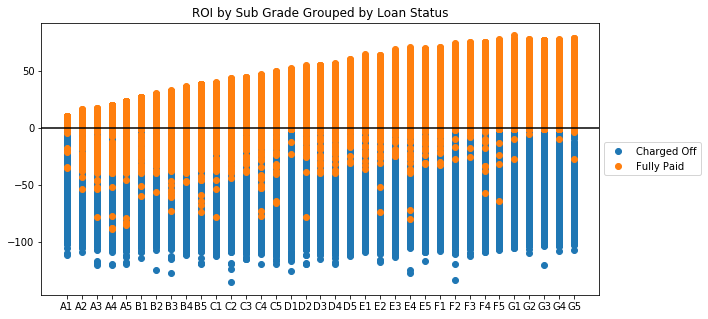

In [11]:
plt.figure(figsize=(10, 5))
groups = data.groupby('loan_status')
for name, group in groups:
    plt.plot(group['sub_grade'], group['ROI'], marker="o", linestyle="", label=name)
plt.axhline(y=0, color='black', linestyle='-')
plt.title('ROI by Sub Grade Grouped by Loan Status')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In the following cell, we find that only 1.13% of loans with a positive ROI were charged off, confirming the visual results from the graph above. This indicates that loans that are charged off would not likely produce a positive gain for an investor, meaning we need to predict which loans will be charged off to avoid those.

In [12]:
pos_roi = data[data['ROI'] > 0]
pos_roi_len = len(pos_roi)
pos_roi_charged_off = pos_roi[pos_roi['loan_status'] == 'Charged Off']
percent_pos_roi_charged_off = (len(pos_roi_charged_off)/pos_roi_len)*100
print(percent_pos_roi_charged_off)

1.1281923194657544


The following two cells show the organization of the data by sub grade to be used in the next two figures. We needed to calculate counts of each subgrade and then counts of charged off and positive ROI for each subgrade to then find percentages of charged off and positive ROI for subgrade.

In [13]:
subgrade_counts = data["sub_grade"].value_counts()
subgrade_counts = pd.DataFrame(subgrade_counts)
subgrade_counts.reset_index(level=0, inplace=True)
subgrade_counts.columns = ['sub_grade', 'count']
subgrade_counts = subgrade_counts.sort_values('sub_grade')
sub_grades = data['sub_grade'].unique()
grades = data['grade'].unique()
grades_sub = []
for g in grades:
    grades_sub.append(g)
    grades_sub.append(g)
    grades_sub.append(g)
    grades_sub.append(g)
    grades_sub.append(g)
    
subgrade_counts['grade'] = grades_sub

In [14]:
charged_off_count = []
pos_roi_count = []
for i in sub_grades:
    temp_sub = data[data['sub_grade'] == i]
    c_o = temp_sub[temp_sub['loan_status'] == 'Charged Off']
    p_r = temp_sub[temp_sub['ROI'] > 0]
    charged_off_count.append(len(c_o))
    pos_roi_count.append(len(p_r))
    
subgrade_counts['charged_off_count'] = charged_off_count
subgrade_counts['pos_roi_count'] = pos_roi_count

subgrade_counts['per_charged_off'] = (subgrade_counts['charged_off_count']/subgrade_counts['count'])*100
subgrade_counts['per_pos_roi'] = (subgrade_counts['pos_roi_count']/subgrade_counts['count'])*100

This graph is a visual representation of the risk of loans for each sub grade and grade of being charged off. As the loan grade decreases, the risk of being charged off, and therefore a negative ROI, increases.

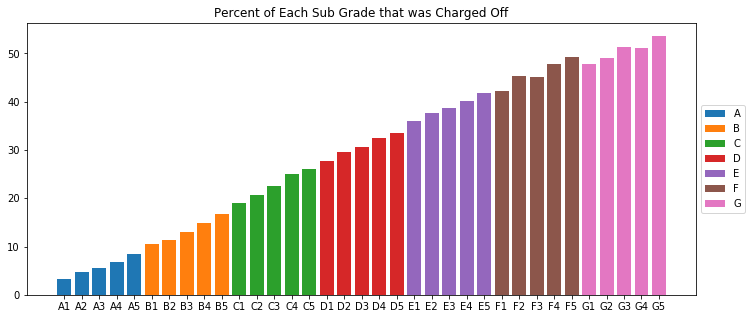

In [15]:
plt.figure(figsize=(12, 5))
groups = subgrade_counts.groupby('grade')
for name, group in groups:
    plt.bar(group['sub_grade'], group['per_charged_off'], label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Percent of Each Sub Grade that was Charged Off')
plt.show()

The following figure shows the inverse of the previous. It also provides some clarity to the first figure grouped by loan status. As shown below, grade A loans are extremely likely to result in a positive ROI. However, as seen in that first figure, the maximum ROI is the lowest of all of the loan grades because of lower interest rates.

After examining the data, we can see that there is a "sweet spot" of loans in the E through G grade with relatively high ROI. To find loans that would fall into this sweet spot in our prediction model, we will try to eliminate loans that would be charged off and then examine lower grade loans that would be fully paid.

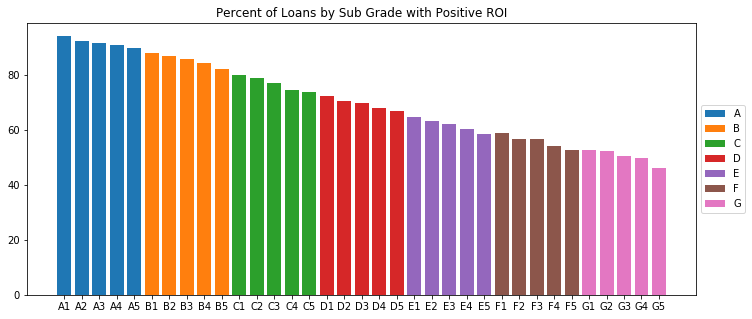

In [16]:
plt.figure(figsize=(12, 5))
groups = subgrade_counts.groupby('grade')
for name, group in groups:
    plt.bar(group['sub_grade'], group['per_pos_roi'], label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Percent of Loans by Sub Grade with Positive ROI')
plt.show()

## Optimal Loans Prediction Tool

In [29]:
# Dropping columns that are not needed
df = data[data['tot_coll_amt'].isna() == False]
to_drop = ['recoveries','collection_recovery_fee','last_pymnt_amnt',
           'acc_open_past_24mths', 'all_util', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 
          'open_acc_6m', 'open_act_il', 'open_act_il', 'open_rv_24m', 'pct_tl_nvr_dlq', 
          'total_cu_tl', 'debt_settlement_flag', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
           'hardship_flag', 'disbursement_method', 'pymnt_plan', 'earliest_cr_line', 'sub_grade', 
          'last_pymnt_d', 'mths_since_recent_inq']
df = df.drop(columns=to_drop)

# Mapping categorical employee length variable to numerical values
df['emp_length'] = df['emp_length'].fillna('nan')
df['emp_length'] = df['emp_length'].replace({'10+ years': 10,
                          '3 years': 3,
                          '4 years': 4,
                          '6 years': 6, 
                          '7 years': 7, 
                          '8 years': 8,
                          '2 years': 2, 
                          '5 years': 5, 
                          '9 years': 9, 
                          '< 1 year':0, 
                          '1 year':1, 
                          'nan': 0})

# Mapping categorical grade variable to numerical values
df['grade'] = df['grade'].replace({'A':1,
                                   'B':2,
                                   'C':3,
                                   'D':4,
                                   'E':5,
                                   'F':6,
                                   'G':7})

#Mapping categorical verification status to numerical values
df['verification_status'] = df['verification_status'].replace({'Source Verified':1,
                                                              'Verified':1,
                                                              'Not Verified':0})
#Mapping categorical employee length to numerical values
df['loan_status'] = df['loan_status'].replace(['Fully Paid','Charged Off'],[1,0])

half = len(df)/2
df = df.dropna(thresh=half,axis=1)

cat_df = pd.get_dummies(df[['term','application_type', 'initial_list_status', 'verification_status',
                            'home_ownership', 'purpose', 'addr_state']])
df.drop(columns = ['term','application_type', 'initial_list_status', 'verification_status',
                   'home_ownership','purpose','addr_state'], inplace=True)
df = df.join(cat_df)

half = len(df)/2
df = df.dropna(thresh=half,axis=1)

In [30]:
cols_to_impute = ['inq_last_6mths','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op',
                  'num_rev_accts','avg_cur_bal','dti','revol_util',
                  'mths_since_recent_bc','bc_open_to_buy','percent_bc_gt_75',
                  'bc_util','mo_sin_old_il_acct']
# Imputing using the mean
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
arr = imputer.fit_transform(df[cols_to_impute].values)

# Function extracts values from lists
def Extract(lst, index):
    return [item[index] for item in lst]

# Replacing columns with missing values with imputed columns
for i in range(len(cols_to_impute)):
    df[cols_to_impute[i]] = Extract(arr,i)

In [31]:
# Creating random sample from data to get a smaller dataset that computer is able to handle
samp = df.sample(frac=0.5, random_state = 42)

# Everything that was not included in the sample
unseen = df[~df.isin(samp)].dropna()

In [32]:
# Initializing independent variables and dependent variable
df_X = samp.drop('loan_status', axis=1)
df_y = samp.loan_status

### Linear Regression

In [40]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.30, stratify = df_y, random_state=42)

# Using linear regression model as a baseline for predicting loan status
reg = LinearRegression()
reg.fit(X_train, y_train)

# Making Prediction on Test dataset
prediction = reg.predict(X_test)

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, prediction))

Coefficient of determination: 0.87


### Feature Selection for Predicting Loan Status

The top most important features for predicting loan status are:
- interest rate
- grade
- dti

In [94]:
# Looking at P values to determine which columns will be better predictors of loan status

"""
Removing : 'home_ownership_NONE', tot_cur_bal, 'acc_now_delinq',  'delinq_amnt', mo_sin_rcnt_tl, 
# purpose_educational', 'purpose_small_business', addr_state_MS, 'addr_state_AR', total_rev_hi_lim
num_tl_90g_dpd_24m,  'addr_state_SD',purpose_renewable_energy, tot_coll_amt, 'home_ownership_MORTGAGE',
 'home_ownership_OTHER','home_ownership_OWN','home_ownership_RENT','addr_state_WV',num_accts_ever_120_pd,
 'addr_state_LA', 'num_sats', 'addr_state_AL', chargeoff_within_12_mth, 'total_acc', 'addr_state_TN',
  'addr_state_OK',  'addr_state_OH', 'addr_state_NY', 'addr_state_NM', 'addr_state_NJ', 'addr_state_NE',
  'addr_state_MO', 'addr_state_MD','chargeoff_within_12_mths'
  
"""
X = df_X[['loan_amnt','int_rate','installment','grade','emp_length','annual_inc','dti',
           'delinq_2yrs','inq_last_6mths','open_acc','revol_bal','revol_util','avg_cur_bal',
          'bc_open_to_buy','bc_util',
           'mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mort_acc',
           'mths_since_recent_bc','num_actv_bc_tl','num_bc_sats','num_bc_tl','num_il_tl',
           'num_op_rev_tl','num_rev_accts','num_tl_op_past_12m','percent_bc_gt_75',
           'pub_rec_bankruptcies','tax_liens','tot_hi_cred_lim','total_bal_ex_mort',
           'total_bc_limit','total_il_high_credit_limit','fico_avg','verification_status',
           'term_ 36 months','term_ 60 months','application_type_Individual',
           'application_type_Joint App','initial_list_status_f','initial_list_status_w',
           'home_ownership_ANY','purpose_car','purpose_credit_card','purpose_debt_consolidation',
           'purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_medical',
           'purpose_moving','purpose_other','purpose_vacation','purpose_wedding','addr_state_AZ',
           'addr_state_CA','addr_state_CO','addr_state_DC','addr_state_HI','addr_state_ID','addr_state_MA',
           'addr_state_ME','addr_state_NC','addr_state_ND','addr_state_NH','addr_state_NV','addr_state_OR',
           'addr_state_RI','addr_state_SC','addr_state_TX','addr_state_UT','addr_state_VA',
           'addr_state_VT','addr_state_WA']]  
y = df_y

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

/Users/brooke/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     931.6
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        02:47:51   Log-Likelihood:            -2.9384e+05
No. Observations:              638892   AIC:                         5.878e+05
Df Residuals:                  638821   BIC:                         5.886e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [95]:
# Columns used for predicting loan status
log_cols = X.columns.to_list()

In [96]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.33,
stratify=y,
random_state=42)

# Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, 
                            bootstrap = True, 
                            max_features = 'auto', 
                            min_samples_leaf = 5, 
                            criterion='gini',
                            random_state=42)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)

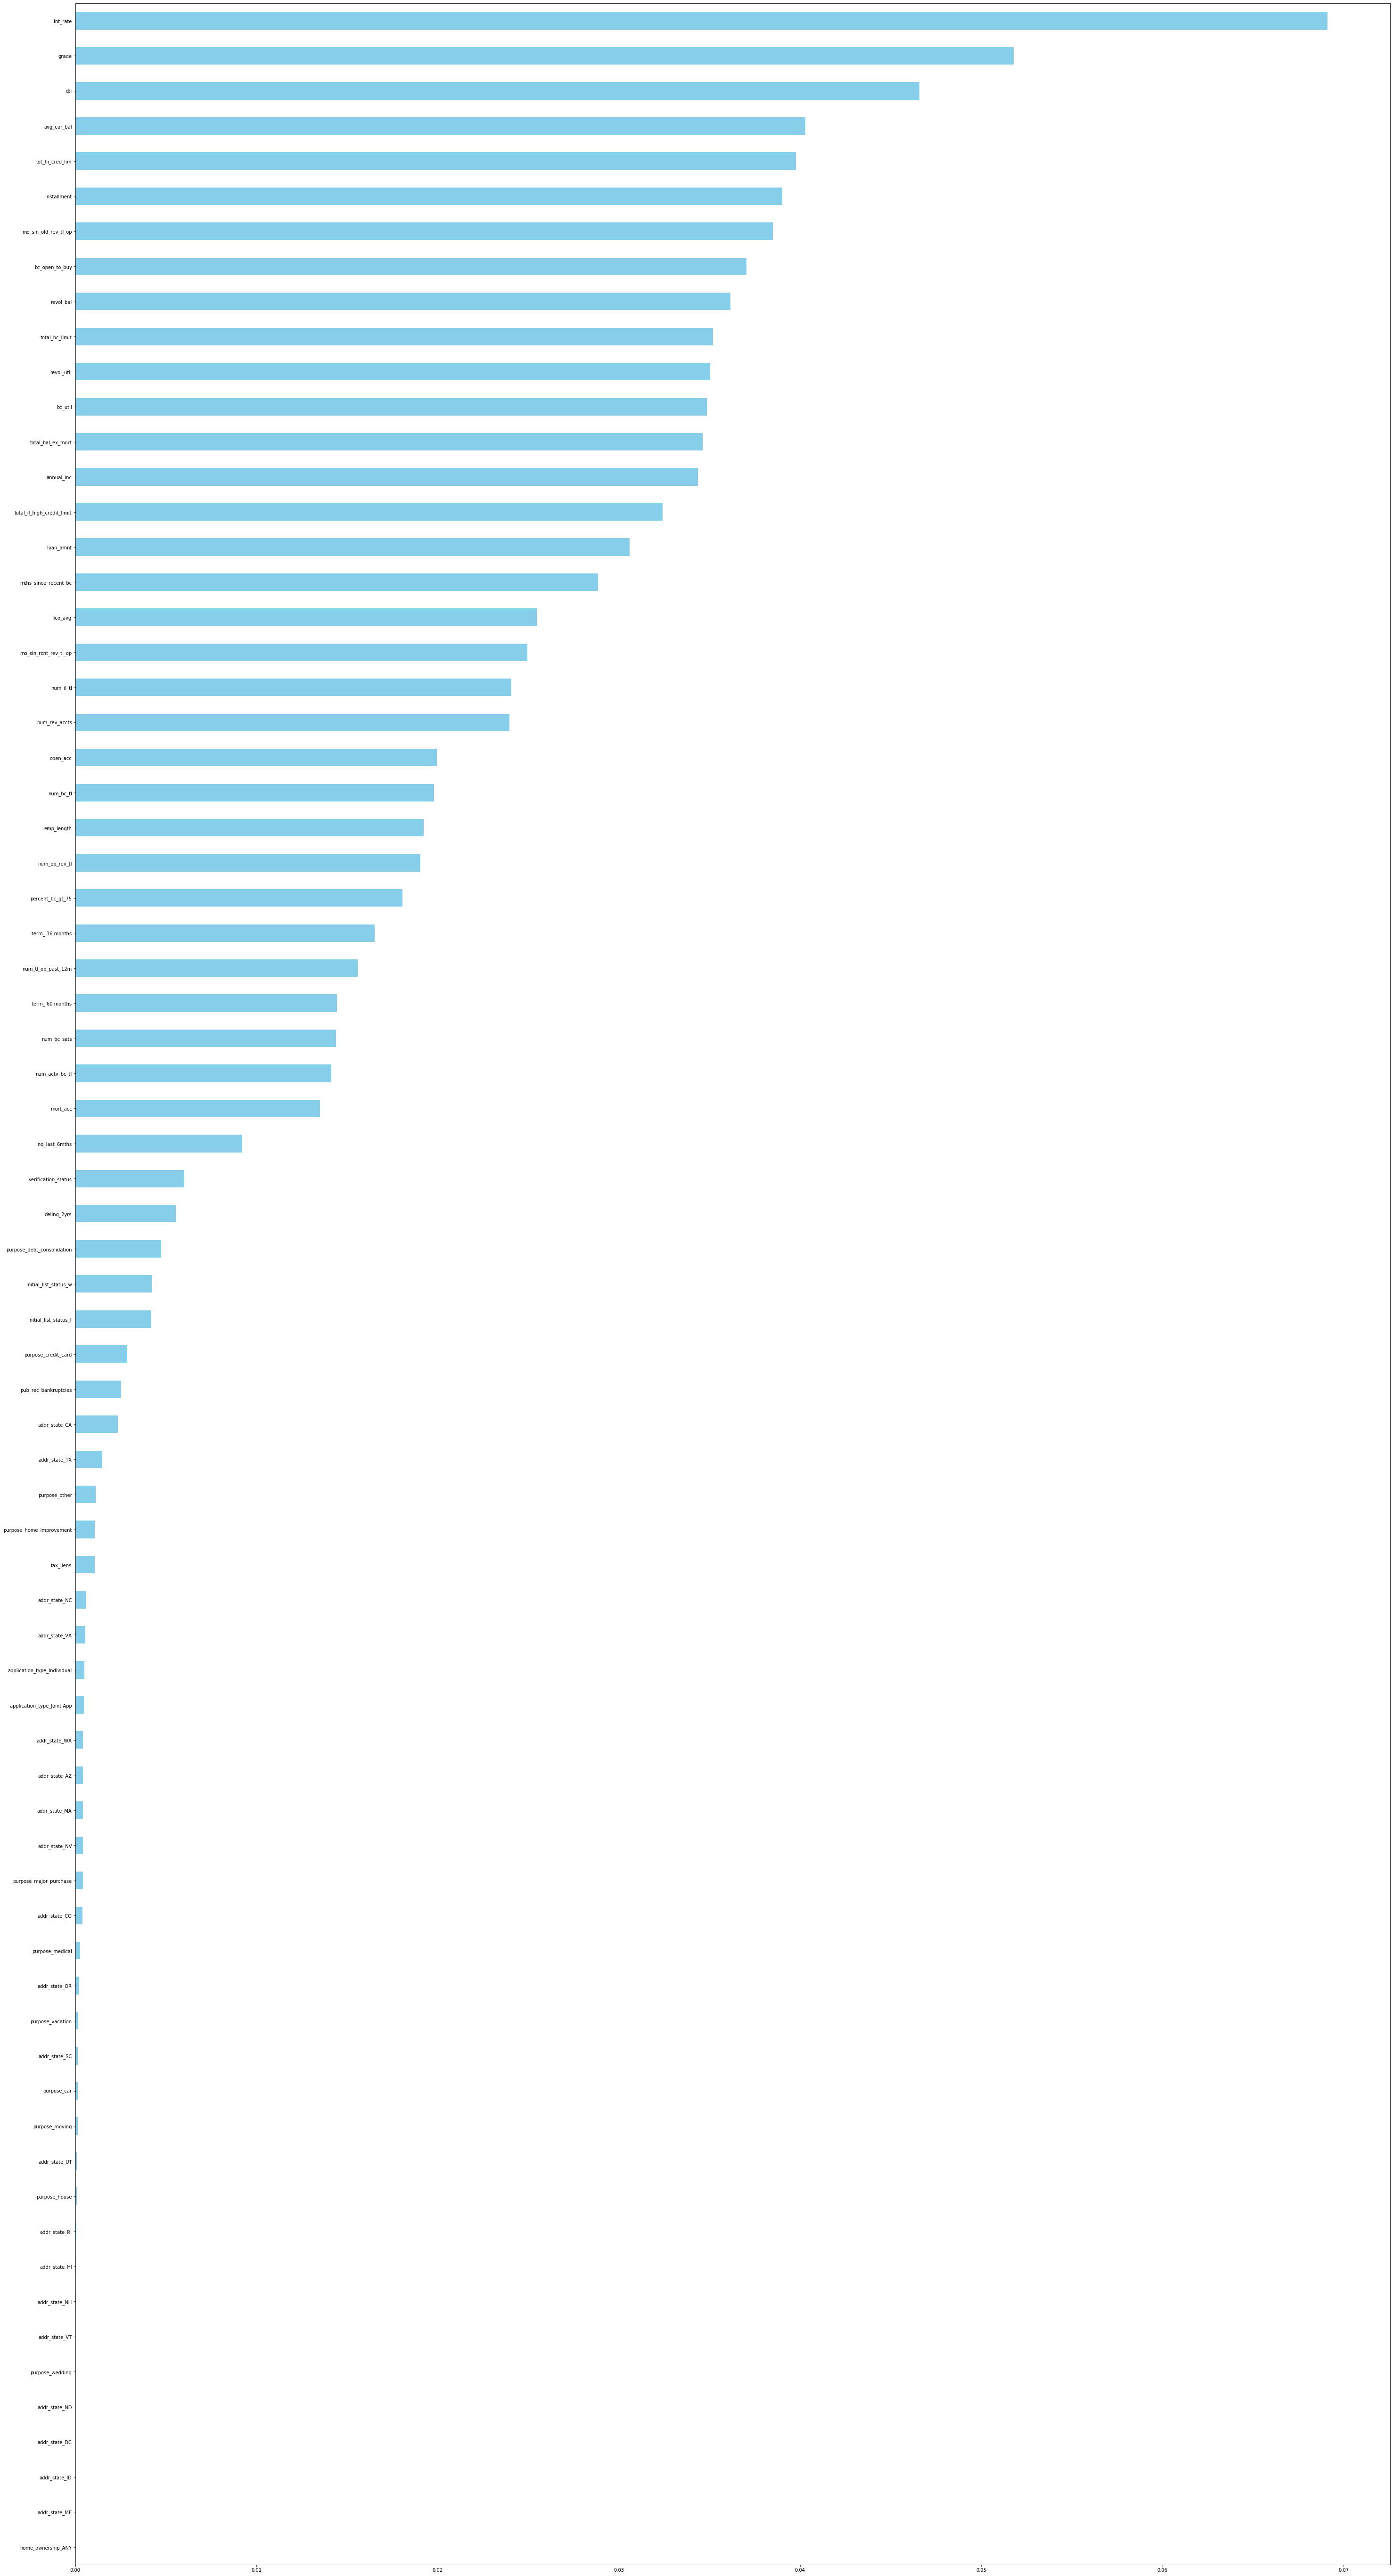

In [97]:
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = X_test.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
plt.figure(figsize=(50,100))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

### Feature Importance for ROI

The top important features for predicting ROI are:
- interest rate
- grade

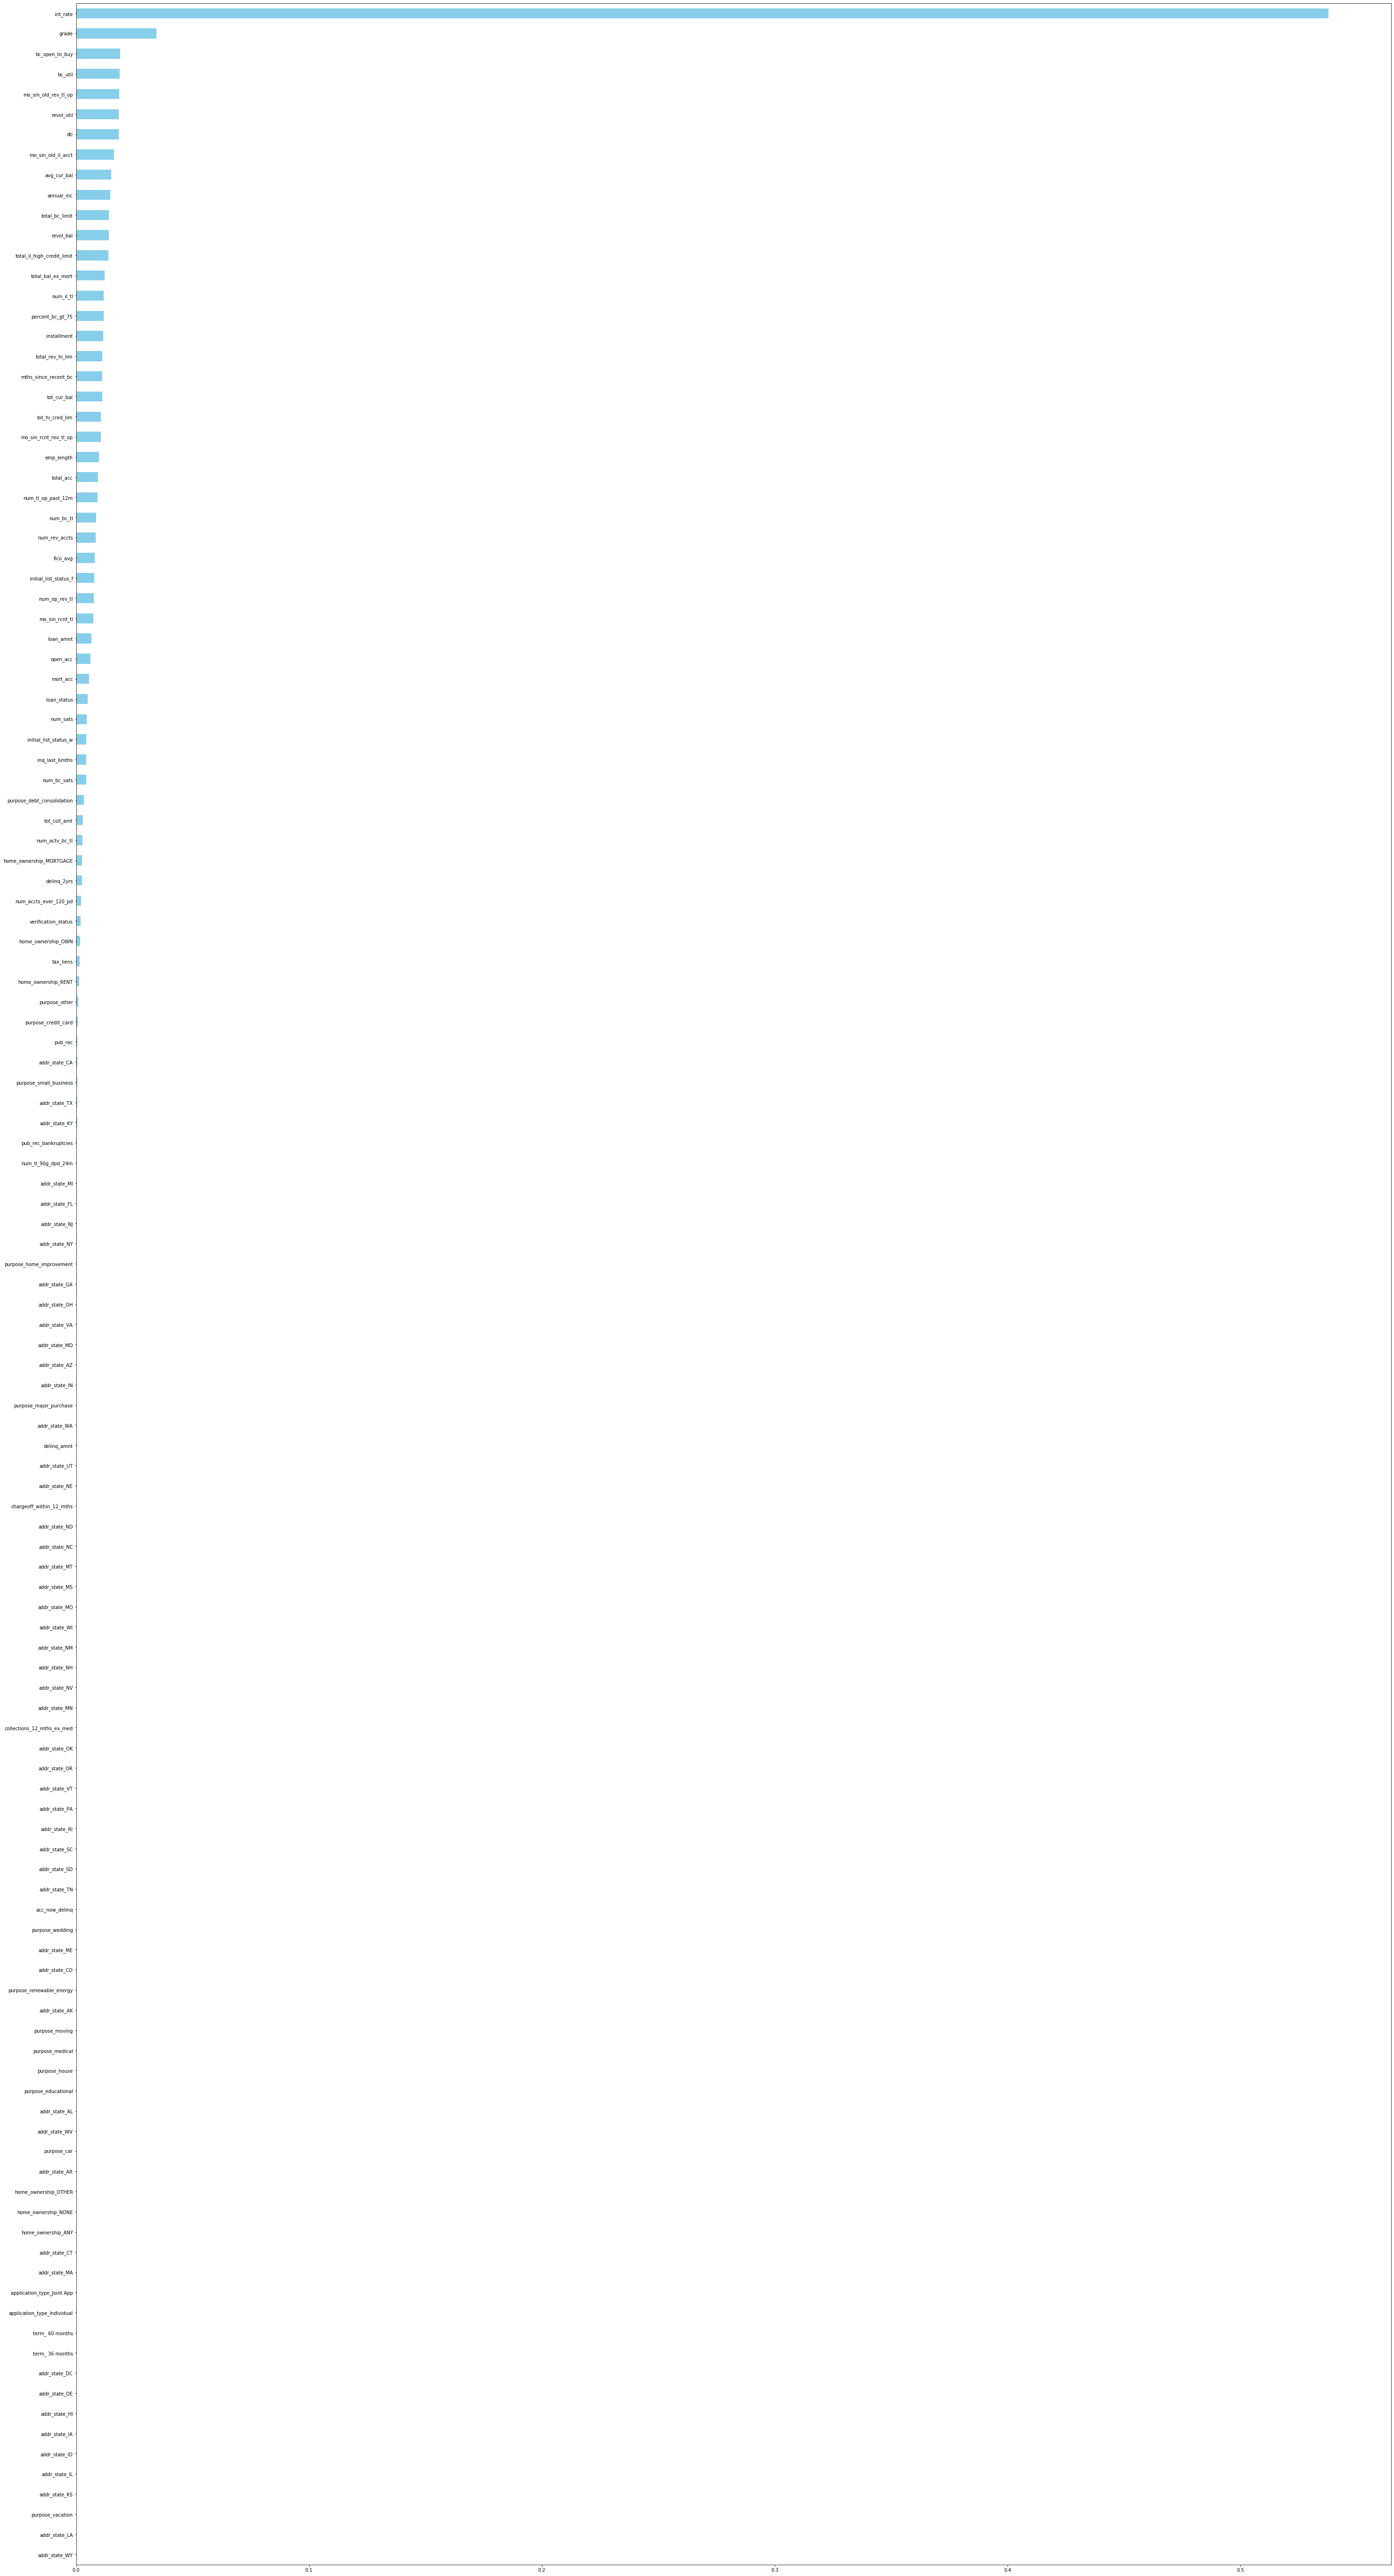

In [101]:
# Preparing data to analyze feature importance of high ROI
roi_X = samp[samp['ROI'] > 50]
roi_y = roi_X.ROI
roi_X = roi_X.drop(columns=['ROI','total_rec_int', 'total_rec_prncp', 'total_rec_late_fee'])
rX_train, rX_test, ry_train, ry_test = train_test_split(roi_X, roi_y, test_size=0.33, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=25, 
                            bootstrap = True, 
                            max_features = 'auto', 
                            min_samples_leaf = 5, 
                            random_state=42)

# Fit 'rf' to the training set
rf.fit(rX_train, ry_train)
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = roi_X.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
plt.figure(figsize=(50,100))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

### Scaling Data

In [47]:
df_X =df_X[log_cols]

# Using scale_numeric to scale independent numeric variables
def scale_numeric(data, numeric_columns, scaler):
    for col in numeric_columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data


scaler = StandardScaler()
df_X = scale_numeric(df_X, df_X.columns, scaler)

### General Logistic Regression Model

/Users/brooke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     38940
           1       1.00      1.00      1.00    152728

    accuracy                           1.00    191668
   macro avg       1.00      0.99      1.00    191668
weighted avg       1.00      1.00      1.00    191668



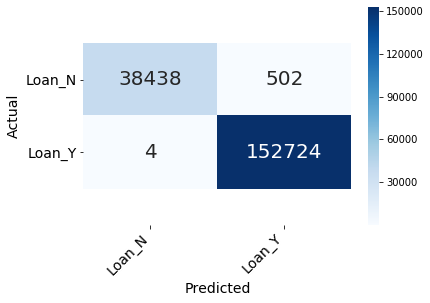

In [48]:
# Splitting dataset into 70% Test, 30% Train
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.30, stratify = df_y, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Creating Logistic Regression Model with Scaler
log = make_pipeline(StandardScaler(),
                    LogisticRegression(random_state=0, max_iter = 500))
log.fit(X_train, y_train)

from sklearn.svm import SVC

#Predict the response for test dataset
y_pred = log.predict(X_test)

# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Loan_N', 'Loan_Y'), ('Loan_N', 'Loan_Y'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update bottom and top margins


# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### Logistic Regression Model for Grades E, F, and G

/Users/brooke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9939302686679528
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8798
           1       0.99      1.00      0.99     12455

    accuracy                           0.99     21253
   macro avg       0.99      0.99      0.99     21253
weighted avg       0.99      0.99      0.99     21253



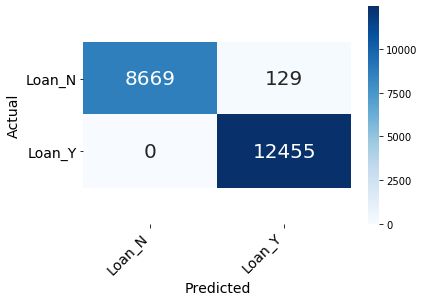

In [49]:
# Creating subset of loans with grades E, F, G then splitting it into train and test
FG = samp.loc[(samp['grade'] == 7)|(samp['grade'] == 6)|(samp['grade'] == 5) ]
FG_X = FG[log_cols]
FG_y = FG.loan_status
fX_train, fX_test, fy_train, fy_test = train_test_split(FG_X, FG_y, test_size=0.33, stratify = FG_y,)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

# Creating Logistic Regression Model for EFG grade loans only
efg_log = make_pipeline(StandardScaler(),
                    LogisticRegression(random_state=0, max_iter = 100000))
efg_log.fit(fX_train, fy_train)

#Scoring EFG Model
efg_log.score(fX_test, fy_test)

#Predict the response for test dataset
fy_pred = efg_log.predict(fX_test)

# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(fy_test, fy_pred))
#best_model(logreg)

# Visualize the confusion matrix to make it easier to read
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(fy_test, fy_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Loan_N', 'Loan_Y'), ('Loan_N', 'Loan_Y'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update t


# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(fy_test, fy_pred))

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Using K-Fold Validation to test 
kf = kf = KFold(n_splits=5)
print(cross_val_score(efg_log, FG_X, FG_y, cv=kf))

/Users/brooke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/brooke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/brooke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/brooke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/brooke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

[0.99386694 0.99487617 0.99417702 0.99479814 0.9947205 ]


### Testing Investment Strategies

All strategies have the same foundation. They are based primarily on the logistic regression model's ability to pick good loans. But there's still more we can do to make the most of investments. Now that we know which loans are safe, we can start looking at individual loans.

In the function above, we are prioritizing employee length and annual income, as these were seen to be important features in the Decision Tree Classifier. We also filter out all loans with bankruptcies, tax liens, income that has not been verified, any delinquencies in the last 2 years and anyone with an employment length less than 5. These filters are in place to decrease risk.

The variation in strategy comes into play when we consider how to diversify our portfolio. In each strategy we aim to invest in 100 loans. Each strategy varies in distribution of grade and the amount of money invested to each loan of a particular grade.

In [52]:
def strategy(n, props, amnt_invested):
    global log_cols
    # Calculates the number of loans to invest in for loans of each grade
    totals = [n*x for x in props]
    new_totals = []
    for x,y in zip(totals, amnt_invested):
        if y!=0:
            new_totals.append(int(x//y))
        else:
            new_totals.append(0)
            
    # Taking a random sample of the data that the models have not seen before 
    # and extracting the columns necessary for predicting loan status       
    invest1 = unseen.sample(n=10000,replace=False)
    invest1_X = invest1.drop(columns=['loan_status'])
    invest1_X = invest1_X[log_cols]
    invest1_y = invest1.loan_status
    invest1_ROI = invest1.ROI
    
    invest1_pred = log.predict(invest1_X)
    invest1_df = invest1_X.copy()
    invest1_df['prediction'] = invest1_pred.copy()
    invest1_df['ROI'] = invest1_ROI.copy()

    invest1_EFG = invest1_df[(invest1_df['grade'] == 7) & (invest1_df['grade'] == 6) | (invest1_df['grade'] == 5)].copy()
    efg_roi = invest1_EFG.ROI
    invest1_EFGX = invest1_EFG[log_cols]

    efg_pred = efg_log.predict(invest1_EFGX)
    invest1_EFGX['prediction'] = efg_pred.copy()
    invest1_EFGX['ROI'] = efg_roi.copy()

    invest1_A = invest1_df[(invest1_df['grade'] == 1) & (invest1_df['prediction']==1)]
    invest1_B = invest1_df[(invest1_df['grade'] == 2) & (invest1_df['prediction']==1)]
    invest1_C = invest1_df[(invest1_df['grade'] == 3) & (invest1_df['prediction']==1)]
    invest1_D = invest1_df[(invest1_df['grade'] == 4) & (invest1_df['prediction']==1)]
    invest1_E = invest1_EFGX[(invest1_EFGX['grade'] == 5) & (invest1_EFGX['prediction']==1)]
    invest1_F = invest1_EFGX[(invest1_EFGX['grade'] == 6) & (invest1_EFGX['prediction']==1)]
    invest1_G = invest1_EFGX[(invest1_EFGX['grade'] == 7) & (invest1_EFGX['prediction']==1)]
    
    
    # Filtering Grade A loans using filters to minimize risk
    a = invest1_A.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    A = a.loc[(a.pub_rec_bankruptcies == 0.0) & (a.tax_liens == 0.0) & (a.verification_status == 1) & 
          (a.delinq_2yrs == 0.0) & (a.emp_length > 5)].sort_values(by='installment').head(new_totals[0])
   
    # Crreating and filliing list of individual amounts invested in each loan
    Aamnt = [amnt_invested[0] for x in range(len(A))]
    
    
    # Filtering Grade B loans using filters to minimize risk
    b = invest1_B.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    B = b.loc[(b.pub_rec_bankruptcies == 0.0) & (b.tax_liens == 0.0) & (b.verification_status == 1) & 
          (b.delinq_2yrs == 0.0) & (b.emp_length > 5)].sort_values(by='installment').head(new_totals[1])

    # Crreating and filliing list of individual amounts invested in each loan
    Bamnt = [amnt_invested[1] for x in range(len(B))]
   

    # Filtering Grade C loans using filters to minimize risk
    c = invest1_C.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    C = c.loc[(c.pub_rec_bankruptcies == 0.0) & (c.tax_liens == 0.0) &
              (c.verification_status == 1)& (c.delinq_2yrs == 0.0) & 
              (c.emp_length > 5)].sort_values(by='installment').head(new_totals[2])
    
    # Crreating and filliing list of individual amounts invested in each loan
    Camnt = [amnt_invested[2] for x in range(len(C))]

    
    # Filtering Grade D loans using filters to minimize risk
    d = invest1_D.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    D = d.loc[(d.pub_rec_bankruptcies == 0.0) & (d.tax_liens == 0.0) & (d.verification_status == 1) & 
          (d.delinq_2yrs == 0.0) & (d.emp_length > 5)].sort_values(by='installment').head(new_totals[3])
    
    # Crreating and filliing list of individual amounts invested in each loan
    Damnt = [amnt_invested[3] for x in range(len(D))]

    
    # Filtering Grade E loans using filters to minimize risk
    e = invest1_E.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    E = e.loc[(e.pub_rec_bankruptcies == 0.0) & (e.tax_liens == 0.0) & (e.verification_status == 1) & 
          (e.delinq_2yrs == 0.0) & (e.emp_length > 5)].sort_values(by='installment').head(new_totals[4])
    
    # Crreating and filliing list of individual amounts invested in each loan
    Eamnt = [amnt_invested[4] for x in range(len(E))]

   

    # Filtering Grade F loans using filters to minimize risk
    f = invest1_F.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    F = f.loc[(f.pub_rec_bankruptcies == 0.0) & (f.tax_liens == 0.0) & (f.verification_status == 1) & 
          (f.delinq_2yrs == 0.0) & (f.emp_length > 5)].sort_values(by='installment').head(new_totals[5])
    
    # Crreating and filliing list of individual amounts invested in each loan
    Famnt = [amnt_invested[5]  for x in range(len(F))]

    
    # Filtering Grade G loans using filters to minimize risk
    g = invest1_G.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    G = g.loc[(g.pub_rec_bankruptcies == 0.0) & (g.tax_liens == 0.0) & (g.verification_status == 1) & 
          (g.delinq_2yrs == 0.0) & (g.emp_length > 5)].sort_values(by='installment').head(new_totals[6])
    
    # Crreating and filliing list of individual amounts invested in each loan 
    Gamnt = [amnt_invested[6] for x in range(len(G))]

    
    # Combining all loans that will be used for investing
    grade_picks = [B, C, D, E, F, G]
    full = A
    for i in range(6):
        full = full.append(grade_picks[i])
    
    # Combining all loans of grades E, F, and G that will be used for investing
    grade_picks = [F, G]    
    EFG_only = E
    for i in range(2):
        EFG_only = full.append(grade_picks[i])
        
    # Combining all individual amounts invested in each loan into a list
    invest_amnt = []
    amnts = [Aamnt, Bamnt,Camnt,Damnt,Eamnt,Famnt,Gamnt]
    for i in range(7):
        invest_amnt.extend(amnts[i])
    
    # Adding investment amounts to datafram of all loans chosen 
    full['invest_amnts'] = invest_amnt
    
    # Calculating the amount invested
    total_invested = full['invest_amnts'].sum()
    
    # Calculating the return
    total_back = (full['ROI']*full['invest_amnts']).sum()
    
    # Calculating average ROI of all loans chosen 
    avg_roi = full['ROI'].mean()

    return(total_invested, total_back, avg_roi, (total_back - total_invested) / total_invested, EFG_only)

In the following test strategies, we looked at different combinations of grade, loan volume, and amount of investment per individual loan. We wanted to find the maximum ROI yield from these strategies to select as the best. Investment strategies A/B Only, A/B Concentrated, and Platform Mix are based on the automated loan picking options that Lending Club provides to investors. We compared these with variations of loan volume with our own ideas to see if LC's options were the best or if we could come up with a more profitable strategy.

#### Investment Strategy #1.1 : (Many Loans, Less Money - A/B Only)

In [53]:
def strat1(n): 
    results = [] 
    keep = strategy(n, [.50,.50,0,0,0,0,0], [25,25,0,0,0,0,0])
    results.append(keep[3])
    return results
strat1_list = []
for i in range(10):
    strat1_list.append(strat1(10000))
print(np.asarray(strat1_list).mean())

8.364425123067054


#### Investment Strategy #1.2 : (Many Loans, Less Money - A/B Concentrated)

In [54]:
def strat12(n): 
    results = [] 
    keep = strategy(n, [.25,.25,.10,.10,.10,.10,.10], [25,25,25,25,25,25,25])
    results.append(keep[3])
    return results
strat12_list = []
for i in range(10):
    strat12_list.append(strat12(10000))
print(np.asarray(strat12_list).mean())

11.62374456740438


#### Investment Strategy #1.3 : (Many Loans, Less Money - Platform Mix)

In [55]:
def strat13(n): 
    results = [] 
    keep = strategy(n, [.1706, 0.2905,0.2878,0.1502,0.0701,0.0238,0.00681], [25,25,25,25,25,25,25])
    results.append(keep[3])
    return results
strat13_list = []
for i in range(10):
    strat13_list.append(strat13(10000))
print(np.asarray(strat13_list).mean())

12.621962003028562


#### Investment Strategy #2.1 : (Few Loans, Lots of Money - A/B Only)

In [56]:
def strat2(n): 
    results = [] 
    keep = strategy(n, [50,50,0,0,0,0,0], [500,500,0,0,0,0,0])
    results.append(keep[3])
    return results
strat2_list = []
for i in range(10):
    strat2_list.append(strat2(10000))
print(np.asarray(strat2_list).mean())

9.38780513889225


#### Investment Strategy #2.2 : (Few Loans, Lots of Money - A/B Concentrated)

In [57]:
def strat22(n): 
    results = [] 
    keep = strategy(n, [.25,.25,.10,.10,.10,.10,.10], [500,500,500,500,500,500,500])
    results.append(keep[3])
    return results
strat22_list = []
for i in range(10):
    strat22_list.append(strat22(10000))
print(np.asarray(strat22_list).mean())

9.68678876181102


#### Investment Strategy #2.3 : (Few Loans, Lots of Money - Platform Mix)

In [58]:
def strat23(n): 
    results = [] 
    keep = strategy(n, [.1706, 0.2905,0.2878,0.1502,0.0701,0.0238,0.00681], [500,500,500,500,500,500,500])
    results.append(keep[3])
    return results
strat23_list = []
for i in range(10):
    strat23_list.append(strat23(10000))
print(np.asarray(strat23_list).mean())

8.99393720910218


#### Investment  Strategy #3 (Only As)

In [59]:
def strat3(n): 
    results = []
    keep = strategy(n, [.1,0,0,0,0,0,0], [25,0,0,0,0,0,0])
    results.append(keep[3])
    return results
strat3_list = []
for i in range(10):
    strat3_list.append(strat3(10000))
print(np.asarray(strat3_list).mean())

5.385205899364867


#### Investment Strategy #4 (Extreme A/B/C)

In [60]:
def strat4(n): 
    results = []
    keep = strategy(n, [.333,.333,.333,0,0,0,0], [500,500,500,0,0,0,0])
    results.append(keep[3])
    return results
strat4_list = []
for i in range(10):
    strat4_list.append(strat4(10000))
print(np.asarray(strat4_list).mean())

7.938653685877776


Strategy 5.1 and 5.2 represent the "EFG Sweet Spot" we found in our first figure of our EDA. Since we removed the loans that were predicted to be charged off, we can get those high ROIs from the lower loan grades. The values for 5.1 and 5.2 are much higher than the Lending Club built-in options and our other ideas above.

#### Investment Strategy #5.1 (Extreme E/F/G) w/ Few Loans, More Money

In [76]:
def strat5_1(n): 
    results = []
    keep = strategy(n, [0,0,0,0,.333,.333,.333], [0,0,0,0,500,500,500])
    results.append(keep[3])
    return results
strat5_1_list = []
for i in range(10):
    strat5_1_list.append(strat5_1(10000))
print(np.asarray(strat5_1_list).mean())

19.47364033000118


#### Investment Strategy #5.2 (Extreme E/F/G) w/ Many Loans, Less Money

In [89]:
def strat5_2(n): 
    results = []
    keep = strategy(n, [0,0,0,0,.333,.333,.333], [0,0,0,0,25,25,25])
    return (keep[3], keep[4])
strat5_2_list = []
for i in range(10):
    strat5_2_list.append(strat5_2(10000)[0])
print(np.asarray(strat5_2_list).mean())

25.222928679969677


Strategy 5.2, which selects E, F, and G loans and invests the minimum amount in each, consistently yields our maximum ROI from the predicted set of fully paid loans. This balances risk with ROI to provide the best investment options. The following table shows the loans recommended to invest in by index according to the `unseen` dataset.

In [90]:
x = strat5_2(10000)
x[1]

,loan_amnt,int_rate,installment,grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_rec_prncp,total_rec_int,total_rec_late_fee,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,verification_status,term_ 36 months,term_ 60 months,application_type_Individual,application_type_Joint App,initial_list_status_f,initial_list_status_w,home_ownership_ANY,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_vacation,purpose_wedding,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_DC,addr_state_HI,addr_state_ID,addr_state_MA,addr_state_ME,addr_state_NC,addr_state_ND,addr_state_NH,addr_state_NV,addr_state_OR,addr_state_RI,addr_state_SC,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,prediction,ROI
618307,1000.0,26.30,40.46,5.0,10.0,110000.0,24.28,0.0,4.0,31.0,13800.0,38.8,1000.0,91.15,0.00,2699.0,4185.00000,72.100000,412.0,1.0,3.0,1.000000,10.0,12.0,56.0,9.0,28.0,88.0,6.0,50.000000,0.0,0.0,123929.0,23045.0,15000.0,16395.0,687.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8.023850
1789709,1200.0,21.00,45.22,5.0,10.0,27926.0,32.15,0.0,1.0,11.0,9658.0,72.1,1200.0,426.06,0.00,14122.0,2.00000,99.900000,162.0,9.0,2.0,9.000000,2.0,2.0,8.0,11.0,8.0,14.0,1.0,100.000000,0.0,0.0,149872.0,29219.0,1900.0,20410.0,687.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,34.149950
288030,2900.0,20.49,108.50,5.0,10.0,55000.0,39.47,0.0,0.0,11.0,15228.0,84.1,2900.0,839.55,0.00,5656.0,1327.00000,87.500000,138.0,12.0,0.0,13.000000,5.0,5.0,6.0,28.0,7.0,8.0,4.0,80.000000,0.0,0.0,71120.0,62217.0,10600.0,53020.0,687.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,27.660500
408581,2875.0,21.99,109.79,5.0,7.0,40000.0,15.06,0.0,1.0,11.0,3311.0,33.8,2875.0,52.62,0.00,3270.0,609.00000,78.200000,48.0,1.0,2.0,17.000000,1.0,2.0,3.0,18.0,7.0,8.0,5.0,50.000000,0.0,0.0,43786.0,16425.0,2800.0,13986.0,667.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.811958
1010939,5000.0,19.99,185.80,5.0,10.0,34000.0,28.59,0.0,1.0,9.0,6452.0,96.3,4950.9,1080.92,30.00,1956.0,83.00000,97.900000,144.0,4.0,0.0,50.000000,2.0,2.0,10.0,20.0,5.0,19.0,2.0,100.000000,0.0,0.0,13812.0,11738.0,4000.0,7112.0,662.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,19.970072
1242300,5050.0,20.20,188.20,5.0,6.0,30540.0,8.29,0.0,2.0,7.0,1821.0,12.7,5050.0,1638.84,0.00,418.0,5760.00000,15.300000,27.0,2.0,0.0,2.000000,3.0,3.0,3.0,5.0,6.0,6.0,4.0,0.000000,0.0,0.0,15735.0,2924.0,6800.0,1435.0,717.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,31.127754
160842,5325.0,18.55,193.99,5.0,10.0,33904.0,28.50,0.0,0.0,11.0,37934.0,96.5,5325.0,1652.86,0.00,15450.0,1316.00000,96.300000,124.0,17.0,2.0,17.000000,5.0,5.0,6.0,4.0,7.0,8.0,0.0,80.000000,0.0,0.0,203385.0,66094.0,35500.0,27615.0,717.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,29.729228
12839,5600.0,20.99,210.96,5.0,7.0,35000.0,11